# Analyzing fluorescent images with OpenCV in Python

Some more text

In [73]:
%matplotlib inline
# import libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [74]:
def make_hsv(x):
    return cv2.cvtColor(x,cv2.COLOR_BGR2HSV)

In [80]:
image = cv2.imread("test_red.jpg")

# crop to exlude scale bar
width, length, _ = image.shape
image = image[:int(width*0.9), :]

print("dimensions of image: {}".format(image.shape))

dimensions of image: (468, 692, 3)


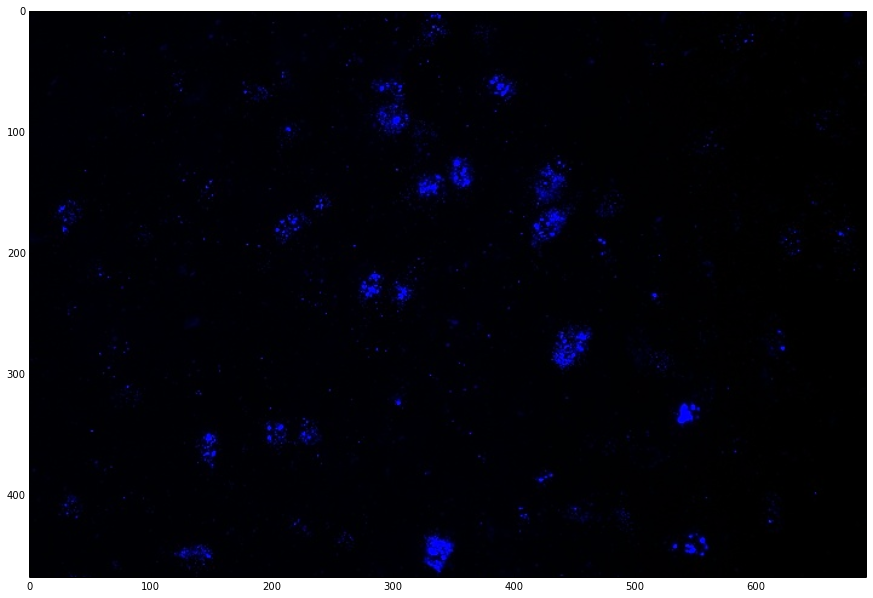

In [81]:
plt.figure(figsize=(15,15))
plt.imshow(image)
plt.show()

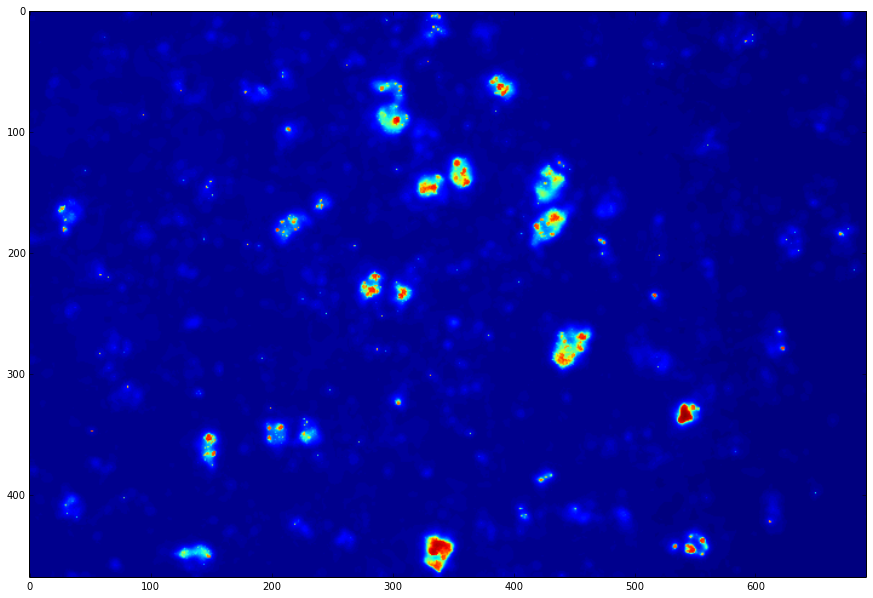

In [82]:
# blur
# blur = cv2.blur(image,(10,10))
blur = cv2.bilateralFilter(image ,9,75,75)

# convert to HSV
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15,15))
plt.imshow(gray)
plt.title("with contours detected")

plt.show()

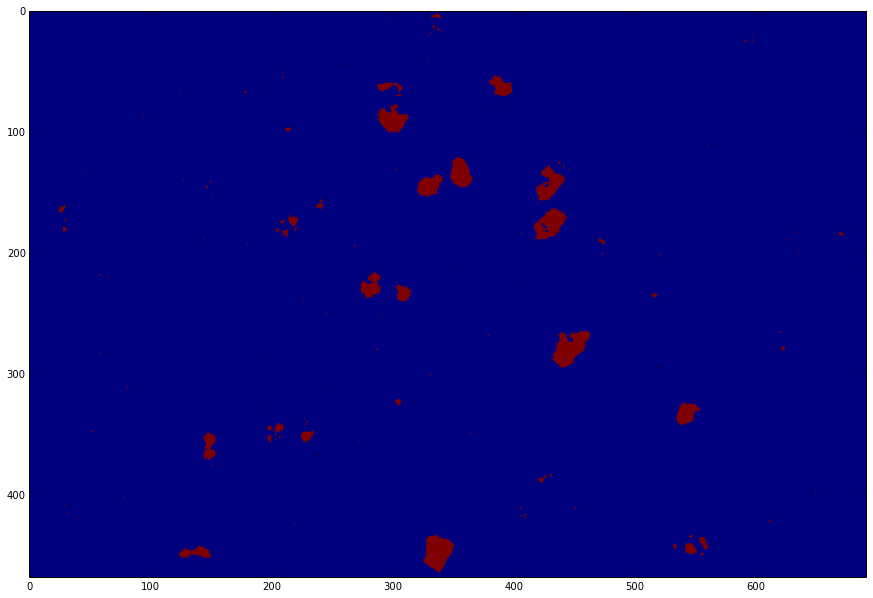

In [83]:
ret,thresh = cv2.threshold(gray,20,255,cv2.THRESH_BINARY)

plt.figure(figsize=(15,15))
plt.title("thresholded")
plt.imshow(thresh)
plt.show()

25, 132


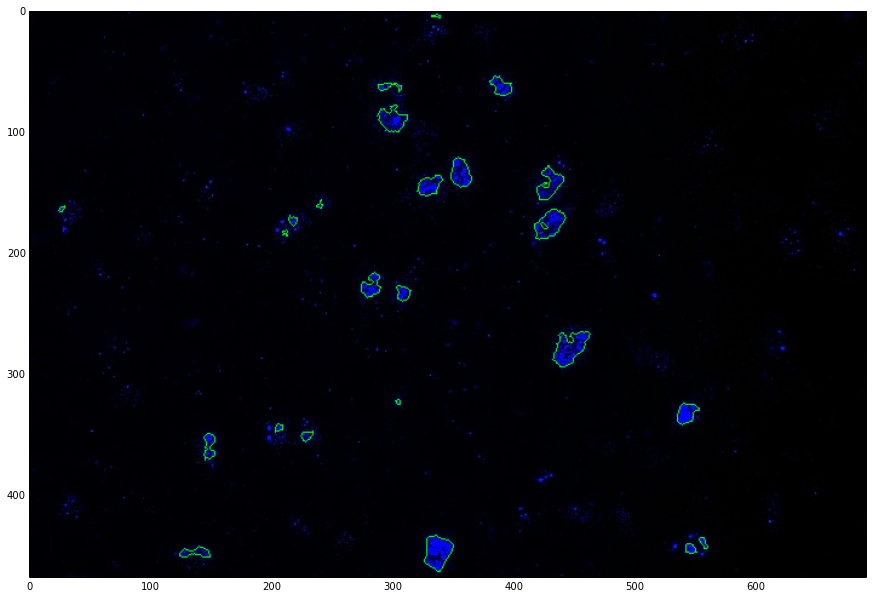

In [84]:
contours = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[0]

# sizes = []
# for c in contours:
#     sizes.append(cv2.contourArea(c))
# print(sizes)

big_countours = [c for c in contours if cv2.contourArea(c) > 10]

print("{}, {}".format(len(big_countours), len(contours)))

cv2.drawContours(image, big_countours, -1, (0,255,0), 1)

plt.figure(figsize=(15,15))
plt.imshow(image)
plt.title("with contours detected")
plt.show()

In [85]:

# # define range of blue color in BGR
# blue1 = np.uint8([[[100,0,0 ]]])
# blue2 = np.uint8([[[255,20,50 ]]])
# lower_blue = make_hsv(blue1)
# upper_blue = make_hsv(blue2)

    
# mask = cv2.inRange(blur, upper_blue, lower_blue)

# plt.figure(figsize=(15,15))
# plt.imshow(mask)
# plt.show()